# Descripción

La compañía de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y te pide que evalúes esa posibilidad.
- Paso 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Paso 2: predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
- Paso 3: predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
- Paso 4: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscación de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.


# Preprocesamiento y exploración de datos

## Inicialización

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from IPython.display import display

## Carga de datos

Carga los datos y haz una revisión básica para comprobar que no hay problemas obvios.

In [ ]:
df = pd.read_csv('data/insurance_us.csv')

Renombramos las columnas para que el código se vea más coherente con su estilo.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
3562,1,48.0,63400.0,1,1
1873,0,22.0,44200.0,1,0
570,1,32.0,39000.0,4,0
302,0,29.0,42500.0,1,0
1631,1,30.0,33500.0,1,0
4240,0,27.0,37100.0,1,0
1308,1,32.0,63300.0,1,0
3441,1,23.0,13500.0,1,0
296,1,26.0,40600.0,4,0
1998,1,38.0,42200.0,2,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# puede que queramos cambiar el tipo de edad (de float a int) aunque esto no es crucial
df['age'] = df['age'].astype('int')

In [8]:
# comprueba que la conversión se haya realizado con éxito
df['age'].dtype

dtype('int64')

In [9]:
# ahora echa un vistazo a las estadísticas descriptivas de los datos.# ¿Se ve todo bien?
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Se observa que los datos en la tabla están en distintas unidades de medida, ya que cada columna representa parámetros diferentes:

**gender**: Es una columna categórica codificada con valores de 0 y 1 para que el modelo pueda procesarla. La proporción de cada categoría podría influir en los resultados; el valor medio está cercano a 0.5, lo que indica una distribución bastante equilibrada entre ambas categorías.

**age**: Representa la edad de los clientes en años, en un rango de 18 a 65. Esto es lógico, dado que abarca el rango laboral promedio de una persona. El 75% de los clientes tienen entre 18 y 37 años, lo cual indica una mayor presencia de adultos jóvenes.

**income**: Representa los ingresos de los clientes. Esta columna tiene valores mucho mayores que las demás, con un rango de 5,300 a 79,000 y un promedio de 39,916. Será importante analizar si este promedio está influido por valores atípicos, ya que la mayoría de los clientes (75%) tiene ingresos por debajo de 46,600. La gran magnitud de esta columna en comparación con las otras podría generar un peso desproporcionado al entrenar el modelo, lo cual sugiere la necesidad de escalarla.

**family_members**: Indica el número de familiares de cada cliente asegurado. La escala de esta columna parece alinearse bien con otras variables numéricas y no debería presentar problemas significativos en el análisis.

**insurance_benefits**: Representa los beneficios de seguro recibidos por cada cliente. La mayoría de los valores en esta columna son cero, lo que sugiere que muchos clientes no han hecho uso de sus beneficios. Este sesgo hacia cero es relevante y puede requerir un tratamiento especial durante el entrenamiento del modelo.

## Análisis exploratorio de datos

Vamos a comprobar rápidamente si existen determinados grupos de clientes observando el gráfico de pares.

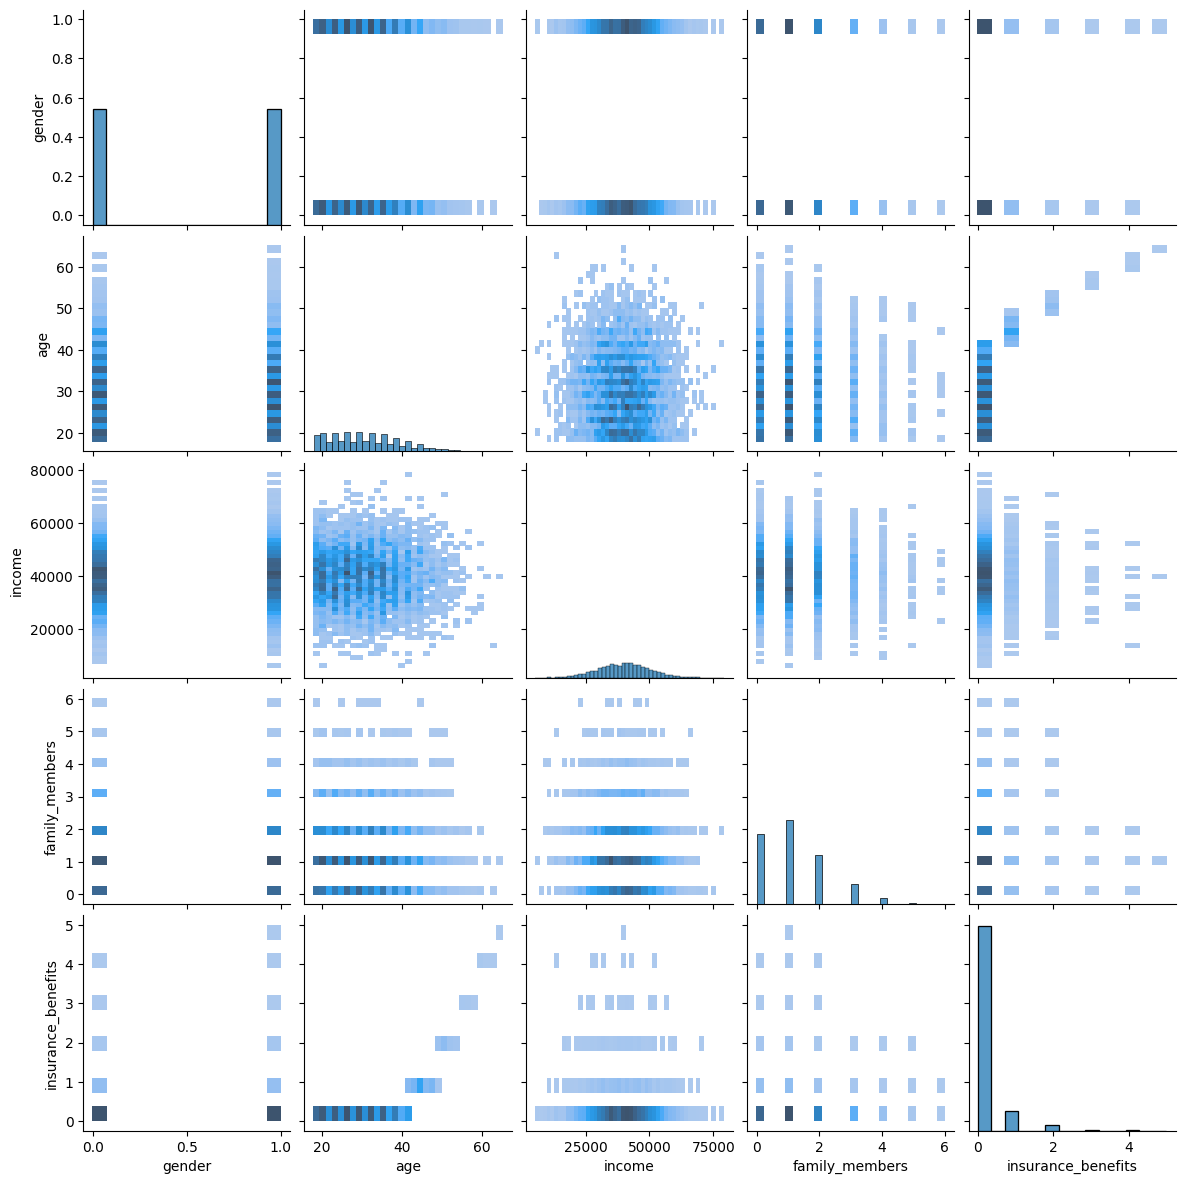

In [10]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

De acuerdo, es un poco complicado detectar grupos obvios (clústeres) ya que es difícil combinar diversas variables simultáneamente (para analizar distribuciones multivariadas). Ahí es donde LA y ML pueden ser bastante útiles.

# Paso 1: Clientes similares

In [11]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [12]:
def get_knn(df, n, k, metric):
    
    """
    Devuelve los k vecinos más cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar  
    :param n: número de objetos para los que se buscan los vecinos más cercanos   
    :param k: número de vecinos más cercanos a devolver
    :param métrica: nombre de la métrica de distancia    """
 
    # Instanciar el modelo de vecinos más cercanos
    nbrs = NearestNeighbors(n_neighbors=k, metric=metric)
    
    # Ajustar el modelo a las características del DataFrame
    nbrs.fit(df[feature_names])

    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

In [ ]:
# Escalar datos
transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())
df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [14]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
1947,0.0,0.415385,0.437975,0.166667,0
3087,0.0,0.476923,0.625316,0.166667,0
4601,1.0,0.384615,0.341772,0.333333,0
3296,0.0,0.415385,0.631646,0.166667,0
4879,1.0,0.323077,0.482278,0.000000,0


Ahora, vamos a obtener registros similares para uno determinado, para cada combinación

In [15]:
result_no_scaled = get_knn(df, n=0, k=5, metric='euclidean')
print("Distancia Euclidiana Datos NO escalados:")
display(result_no_scaled)

Distancia Euclidiana Datos NO escalados:


,gender,age,income,family_members,insurance_benefits,distance
0,1,41,49600.0,1,0,0.000000
2022,1,41,49600.0,0,0,1.000000
1225,0,42,49600.0,0,1,1.732051
4031,1,44,49600.0,2,1,3.162278
3424,0,38,49600.0,0,0,3.316625


In [16]:
result_no_scaled = get_knn(df, n=0, k=5, metric='manhattan')
print("Distancia Manhattan Datos NO escalados:")
display(result_no_scaled)

Distancia Manhattan Datos NO escalados:


,gender,age,income,family_members,insurance_benefits,distance
0,1,41,49600.0,1,0,0.0
2022,1,41,49600.0,0,0,1.0
1225,0,42,49600.0,0,1,3.0
4031,1,44,49600.0,2,1,4.0
3424,0,38,49600.0,0,0,5.0


In [17]:
# Ejemplo: Distancia Euclidiana, datos escalados
result_scaled = get_knn(df_scaled, n=0, k=5, metric='euclidean')
print("Distancia Euclidiana Datos escalados:")
display(result_scaled)

Distancia Euclidiana Datos escalados:


,gender,age,income,family_members,insurance_benefits,distance
0,1.0,0.630769,0.627848,0.166667,0,0.000000
2689,1.0,0.630769,0.634177,0.166667,0,0.006329
133,1.0,0.615385,0.636709,0.166667,0,0.017754
4869,1.0,0.646154,0.637975,0.166667,1,0.018418
3275,1.0,0.646154,0.651899,0.166667,1,0.028550


In [18]:
result_scaled = get_knn(df_scaled, n=0, k=5, metric='manhattan')
print("Distancia Manhattan Datos escalados:")
display(result_scaled)

Distancia Manhattan Datos escalados:


,gender,age,income,family_members,insurance_benefits,distance
0,1.0,0.630769,0.627848,0.166667,0,0.000000
2689,1.0,0.630769,0.634177,0.166667,0,0.006329
133,1.0,0.615385,0.636709,0.166667,0,0.024245
4869,1.0,0.646154,0.637975,0.166667,1,0.025511
3365,1.0,0.630769,0.596203,0.166667,0,0.031646


Respuestas a las preguntas

**¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?** 

El escalado de los datos tiene un impacto significativo en el desempeño del algoritmo kNN porque las métricas de distancia, como la Euclidiana y la Manhattan, son sensibles a las magnitudes de las características. En el caso de datos no escalados, las características con valores más grandes, como el income, dominan las distancias calculadas, mientras que características con valores más pequeños, como gender, tienen poca influencia en la determinación de los vecinos más cercanos.

Al escalar los datos, cada característica contribuye de manera proporcional al cálculo de la distancia, lo que mejora la identificación de similitudes reales entre los datos. Esto es crucial en tareas de clasificación, ya que permite agrupar objetos de manera más precisa en función de todas las características relevantes.

**¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?** 

Los resultados obtenidos al usar la métrica de distancia Manhattan y Euclidiana son bastante similares. En los datos no escalados, la diferencia es de 1 o 2 puntos, mientras que en los datos escalados, esta diferencia es de aproximadamente 0.01. Estas diferencias pueden considerarse significativas dependiendo del contexto del modelo y la métrica utilizada.

La distancia Euclidiana enfatiza diferencias grandes debido a su cálculo cuadrático, lo que puede ser beneficioso cuando las características tienen distribuciones más homogéneas o cuando se desea resaltar grandes discrepancias. Sin embargo, también es más sensible a problemas de escalado, ya que las características con valores más grandes tendrán mayor influencia.

Por otro lado, la distancia Manhattan es más robusta frente a valores extremos, ya que calcula la suma de diferencias absolutas. Esto la hace adecuada para datos con características heterogéneas o donde se desea evitar el impacto desproporcionado de valores extremos.

En este caso particular, al usar datos escalados, la distancia Euclidiana parece ofrecer una mejor precisión al identificar similitudes más sutiles, posiblemente debido a cómo destaca patrones más pequeños. Sin embargo, ambas métricas presentan resultados muy cercanos, lo que indica que la elección dependerá del problema específico y la naturaleza de los datos.

# Paso 2. ¿Es probable que el cliente reciba una prestación del seguro?

En términos de machine learning podemos considerarlo como una tarea de clasificación binaria.

Con el valor de `insurance_benefits` superior a cero como objetivo, evalúa si el enfoque de clasificación kNN puede funcionar mejor que el modelo dummy.

- Construir un clasificador basado en KNN y mide su calidad con la métrica F1 para k=1...10 tanto para los datos originales como para los escalados. Sería interesante observar cómo k puede influir en la métrica de evaluación y si el escalado de los datos provoca alguna diferencia. 

- Construir un modelo dummy que, en este caso, es simplemente un modelo aleatorio. Debería devolver "1" con cierta probabilidad. Probemos el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestación del seguro, 0.5, 1.

La probabilidad de pagar cualquier prestación del seguro puede definirse como
$$
P\{\text{prestación de seguro recibida}\}=\frac{\text{número de clientes que han recibido alguna prestación de seguro}}{\text{número total de clientes}}.
$$

Divir todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30.

In [ ]:
# Clasifica los datos para definir una columna objetivo
def set_target_split(data):
        """
    Crea la columna 'insurance_benefits_received' basada en si insurance_benefits > 0.
    Divide el DataFrame en conjuntos de entrenamiento y prueba.
    Devuelve: train_X, test_X, train_y, test_y
    """
        # Clasifica los datos
        data['insurance_benefits_received'] = 0
        data.loc[data['insurance_benefits'] > 0,'insurance_benefits_received']=1
        # Divide los datos 
        train_df, test_df = train_test_split(data, test_size=0.3, random_state=1234)
        train_X, test_X =  train_df[feature_names], test_df[feature_names]
        train_y, test_y = train_df['insurance_benefits_received'], test_df['insurance_benefits_received']
        return train_X, test_X, train_y, test_y

In [ ]:
train_X, test_X, train_y, test_y = set_target_split(df)
sc_train_X, sc_test_X, sc_train_y, sc_test_y = set_target_split(df_scaled)

In [21]:
def eval_classifier(y_true, y_pred):
    """
    Evalúa el modelo con métricas de F1 y matriz de confusión.
    """
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de confusión')
    print(cm)

In [22]:
# Crear y entrenar modelo de clasificacion KNeighbors
def create_knn_model(train_X, test_X, train_y, test_y):
    """
    Entrena y evalúa el modelo KNN para k=1...10.
    """
    f1_scores = [] # Guardar los F1 para graficar más adelante
    for k in range(1,11):
        model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
        model.fit(train_X, train_y)
        predict_y = model.predict(test_X)
    
        print(f"Resultados para 𝑘={k}:")
        eval_classifier(test_y, predict_y)  # Evalúa el modelo
        print("-" * 30)  # Separador para claridad
        # Guardar F1 para análisis posterior
        f1_scores.append(sklearn.metrics.f1_score(test_y, predict_y))
    return f1_scores

In [23]:
# comprueba el desequilibrio de clases con value_counts()
train_y.value_counts()

0    3109
1     391
Name: insurance_benefits_received, dtype: int64

Existe un evidente desequilibrio entre los datos, sólo alrededor del 10% de estos corresponden a clientes que cobraron algún seguro

In [24]:
# Crear modelos para datos no escalados y escalados
print('Modelos con datos NO escalados:\n' ,('=')*30)
f1_no_scaling = create_knn_model(train_X, test_X, train_y, test_y)

Modelos con datos NO escalados:
Resultados para 𝑘=1:
F1: 0.63
Matriz de confusión
[[0.85933333 0.02533333]
 [0.05066667 0.06466667]]
------------------------------
Resultados para 𝑘=2:
F1: 0.38
Matriz de confusión
[[0.87666667 0.008     ]
 [0.08666667 0.02866667]]
------------------------------
Resultados para 𝑘=3:
F1: 0.41
Matriz de confusión
[[0.87333333 0.01133333]
 [0.08266667 0.03266667]]
------------------------------
Resultados para 𝑘=4:
F1: 0.21
Matriz de confusión
[[0.882      0.00266667]
 [0.10133333 0.014     ]]
------------------------------
Resultados para 𝑘=5:
F1: 0.21
Matriz de confusión
[[0.87933333 0.00533333]
 [0.10133333 0.014     ]]
------------------------------
Resultados para 𝑘=6:
F1: 0.11
Matriz de confusión
[[0.88333333 0.00133333]
 [0.10866667 0.00666667]]
------------------------------
Resultados para 𝑘=7:
F1: 0.11
Matriz de confusión
[[0.88133333 0.00333333]
 [0.10866667 0.00666667]]
------------------------------
Resultados para 𝑘=8:
F1: 0.04
Matriz de conf

El modelo muestra un sesgo hacia la clase mayoritaria (0) debido al desequilibrio de los datos. Esto se refleja en las matrices de confusión, donde la mayoría de las predicciones caen en la clase 0, independientemente de los valores reales.

A medida que $k$ aumenta, el modelo considera más vecinos al hacer la predicción. Como los datos no están escalados, las distancias entre puntos no reflejan adecuadamente las relaciones reales, lo que perjudica la capacidad del modelo para identificar correctamente la clase minoritaria (1). Esto aumenta los falsos positivos y reduce los verdaderos positivos, como bien observaste.

El F1-Score disminuye significativamente con valores mayores de $k$, lo que confirma que el modelo tiene cada vez más dificultades para equilibrar precisión y sensibilidad al identificar la clase 1.

In [25]:
print('Modelos con datos escalados:\n' ,('=')*30)
f1_scaling = create_knn_model(sc_train_X, sc_test_X, sc_train_y, sc_test_y)

Modelos con datos escalados:
Resultados para 𝑘=1:
F1: 0.95
Matriz de confusión
[[0.882      0.00266667]
 [0.008      0.10733333]]
------------------------------
Resultados para 𝑘=2:
F1: 0.92
Matriz de confusión
[[0.88466667 0.        ]
 [0.018      0.09733333]]
------------------------------
Resultados para 𝑘=3:
F1: 0.95
Matriz de confusión
[[0.88266667 0.002     ]
 [0.00866667 0.10666667]]
------------------------------
Resultados para 𝑘=4:
F1: 0.93
Matriz de confusión
[[8.84000000e-01 6.66666667e-04]
 [1.46666667e-02 1.00666667e-01]]
------------------------------
Resultados para 𝑘=5:
F1: 0.93
Matriz de confusión
[[0.88133333 0.00333333]
 [0.01133333 0.104     ]]
------------------------------
Resultados para 𝑘=6:
F1: 0.93
Matriz de confusión
[[8.84000000e-01 6.66666667e-04]
 [1.53333333e-02 1.00000000e-01]]
------------------------------
Resultados para 𝑘=7:
F1: 0.94
Matriz de confusión
[[0.88066667 0.004     ]
 [0.01       0.10533333]]
------------------------------
Resultados para

El modelo KNN muestra una mejora notable al trabajar con datos escalados. Esto se refleja en un incremento significativo en el recall, permitiendo detectar más verdaderos positivos sin sacrificar precisión, y un F1-Score alto y consistente para diferentes valores de $k$. A diferencia de enfoques como bosques aleatorios que podrían requerir balancear las clases, KNN escalado logra un buen desempeño directamente, gracias a su dependencia en distancias bien ajustadas. Además, su estabilidad frente a cambios en 
$k$ demuestra una robustez que lo hace adecuado para este problema.

El gráfico a continuacion muestra el rendimiento de los modelos KNN entrenados con los datos No escalados y con los datos escalados.

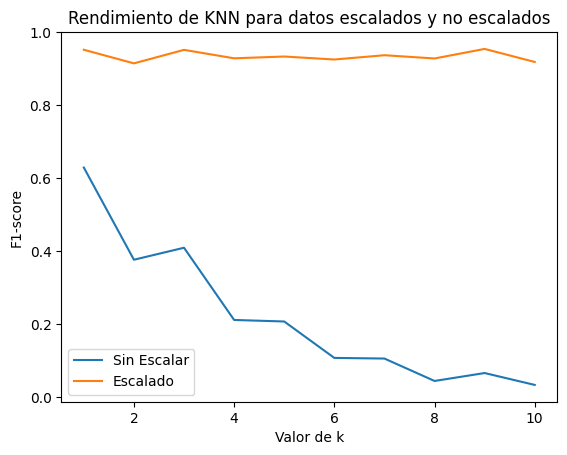

In [26]:
# Opcional: Graficar los F1-scores para cada valor de k
import matplotlib.pyplot as plt

plt.plot(range(1, 11), f1_no_scaling, label="Sin Escalar")
plt.plot(range(1, 11), f1_scaling, label="Escalado")
plt.xlabel("Valor de k")
plt.ylabel("F1-score")
plt.title("Rendimiento de KNN para datos escalados y no escalados")
plt.legend()
plt.show()

In [27]:
# generar la salida de un modelo aleatorio
def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [28]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'La probabilidad: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size=len(df))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

La probabilidad: 0.00
F1: 0.00
Matriz de confusión
[[0.8872 0.    ]
 [0.1128 0.    ]]

La probabilidad: 0.11
F1: 0.12
Matriz de confusión
[[0.7914 0.0958]
 [0.0994 0.0134]]

La probabilidad: 0.50
F1: 0.20
Matriz de confusión
[[0.456  0.4312]
 [0.053  0.0598]]

La probabilidad: 1.00
F1: 0.20
Matriz de confusión
[[0.     0.8872]
 [0.     0.1128]]



***Modelo dummy con probabilidad 0:***
Este caso simplemente predice que todos los casos pertenecen a la clase negativa (0). Como esperabas, tiene precisión perfecta porque nunca predice falsos positivos, pero su recall es 0, lo que lleva a un F1-score de 0. Este modelo no es útil en la práctica.

***Modelo dummy con probabilidad real de los datos (0.11):***
Aquí, el modelo dummy predice la clase positiva (1) en la proporción observada en los datos reales. Esto hace que el recall aumente, ya que predice correctamente algunos de los casos positivos, pero al costo de reducir la precisión (por falsos positivos). El F1-score mejora en comparación con el modelo con probabilidad 0.

***Modelo dummy con probabilidad 0.5:***
Este modelo divide sus predicciones entre clases positivas y negativas casi uniformemente, lo que genera un gran aumento de falsos positivos y falsos negativos. Aunque mejora ligeramente el recall, la precisión sufre drásticamente, y el F1-score apenas llega a 0.2.

***Modelo dummy con probabilidad 1:***
Este caso predice que todos los casos pertenecen a la clase positiva (1). Tiene el recall más alto posible (predice todos los positivos correctamente), pero su precisión es nula porque predice positivos incluso donde no los hay, dando nuevamente un F1-score muy bajo.

***Conclusión sobre KNN vs. dummy:***
El modelo KNN claramente supera al modelo dummy en todas las probabilidades evaluadas. Esto confirma que el KNN está aprendiendo patrones significativos de los datos, mientras que el modelo dummy solo genera predicciones basadas en probabilidades sin interpretar patrones.


# Paso 3. Regresión (con regresión lineal)

Con `insurance_benefits` como objetivo, se evaluará cuál sería la RECM de un modelo de regresión lineal.

Construir una implementacion propia de Regresion Lineal. Para ello, hay que considerar cómo está formulada la solución de la tarea de regresión lineal en términos de LA. Comprueba la RECM tanto para los datos originales como para los escalados.

¿Existe alguna diferencia en la RECM con respecto a estos dos casos?

Denotemos
- $X$: matriz de características; cada fila es un caso, cada columna es una característica, la primera columna está formada por unidades
- $y$ — objetivo (un vector)
- $\hat{y}$ — objetivo estimado (un vector)
- $w$ — vector de pesos
La tarea de regresión lineal en el lenguaje de las matrices puede formularse así:
$$
y = Xw
$$

El objetivo de entrenamiento es entonces encontrar esa $w$  que minimice la distancia L2 (ECM) entre $Xw$ y $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que hay una solución analítica para lo anteriormente expuesto:
$$
w = (X^T X)^{-1} X^T y
$$

La fórmula anterior puede servir para encontrar los pesos $w$ y estos últimos pueden utilizarse para calcular los valores predichos
$$
\hat{y} = X_{val}w
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30. Utiliza la métrica RECM para evaluar el modelo.

In [29]:
class MyLinearRegression:
    
    def __init__(self):
        """crea el atributo weighs para la clase MyLinearRegression"""
        self.weights = None
    
    def fit(self, X, y):
        """Entrena el modelo"""
        #añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y

    def predict(self, X):
        """Predice los cuantos clientes cobraran seguros"""
        # añadir las unidades
        X2 = np.append(np.ones([len(X),1]), X, axis=1)
        y_pred = X2 @ self.weights
        
        return y_pred

In [30]:

def eval_regressor(y_true, y_pred):
    """Evalua modelos de Regresion Lineal"""
    rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')   
    r2_score = sklearn.metrics.r2_score(y_true, y_pred)
    print(f'R2: {r2_score:.2f}')    
    return rmse, r2_score

In [31]:
def create_train_lr(data):
    """
    Separa los datos del dataframe en caracteristicas y objetivos
    Divide los datos para entrenamiento y prueva con proporcion 70:30
    Crea y entrena un modelo de Regresion Lineal con la clase MyLinearRegression
    Imprime el peso de cada una de las caracteristicas para el modelo
    Evalua El RMSE y R2 del modelo"""
    
    X = data[['age', 'gender', 'income', 'family_members']].to_numpy()
    y = data['insurance_benefits'].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

    lr = MyLinearRegression()

    lr.fit(X_train, y_train)
    
    # Imprime con tabulación 
    print(f"{'Feature':<15} {'Weight':<15}")  # Encabezados con ancho fijo
    print("-" * 30)
    for name, weight in zip(feature_names, lr.weights):
        print(f"{name:<15} :{weight:<15.6e}")  # Cada columna alineada
    print("=" * 30)
    y_test_pred = lr.predict(X_test)
    return eval_regressor(y_test, y_test_pred)

In [32]:
lr_model_normal_data = create_train_lr(df)

Feature         Weight         
------------------------------
gender          :-9.435390e-01  
age             :3.574955e-02   
income          :1.642727e-02   
family_members  :-2.607437e-07  
RMSE: 0.34
R2: 0.43


In [33]:
lr_model_scaled_data = create_train_lr(df_scaled)

Feature         Weight         
------------------------------
gender          :-9.435390e-01  
age             :2.323721e+00   
income          :1.642727e-02   
family_members  :-2.059875e-02  
RMSE: 0.34
R2: 0.43


A pesar de las diferencias en el vector de pesos, los valores de ***RMSE*** y ***R²*** son iguales para los modelos de regresión lineal con datos escalados y no escalados. Esto confirma que el escalado de las características no afecta la calidad del modelo en términos de error y capacidad explicativa, pero sí cambia la magnitud de los coeficientes.

# Paso 4. Ofuscar datos

Lo mejor es ofuscar los datos multiplicando las características numéricas (recuerda que se pueden ver como la matriz $X$) por una matriz invertible $P$. 

$$
X' = X \times P
$$

Trata de hacerlo y comprueba cómo quedarán los valores de las características después de la transformación. Por cierto, la propiedad de invertibilidad es importante aquí, así que asegúrate de que $P$ sea realmente invertible.

Puedes revisar la lección 'Matrices y operaciones matriciales -> Multiplicación de matrices' para recordar la regla de multiplicación de matrices y su implementación con NumPy.

In [34]:
# Selecciona la info
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [35]:
X = df_pn.to_numpy()

Generar una matriz aleatoria $P$.

In [36]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Comprobar que la matriz P sea invertible

In [37]:
P_inv = np.linalg.inv(P)

La matriz es inversible ya que no se generó ningún error

In [38]:
X_= X @ P
print(X_)

[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]


**¿Puedes adivinar la edad o los ingresos de los clientes después de la transformación?**

No parece fácil adivinar cualquier información con esta transformacion, ya que lo unico que mantiene de la matriz original es la cantidad de columnas

**¿Puedes recuperar los datos originales de $X'$ si conoces $P$? Intenta comprobarlo a través de los cálculos moviendo $P$ del lado derecho de la fórmula anterior al izquierdo. En este caso las reglas de la multiplicación matricial son realmente útiles**

In [39]:
X_recovered = X_ @ P_inv 
# Comparar X_recovered con X original
print("¿Recuperación exitosa?", np.allclose(X, X_recovered))

¿Recuperación exitosa? True


Muestra los tres casos para algunos clientes
- Datos originales
- El que está transformado
- El que está invertido (recuperado)

In [40]:
# Datos Originaales
print(X[:5])

[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 [0.00e+00 2.10e+01 4.17e+04 2.00e+00]
 [1.00e+00 2.80e+01 2.61e+04 0.00e+00]]


In [41]:
# Datos Ofuscados
print(X_[:5])

[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 [ 5345.60393712 18803.22720286 15479.14837264 38663.06186284]
 [ 3347.17673462 11782.82928336  9699.99894205 24211.27337753]]


In [42]:
# Datos Recuperados
print( X_recovered[:5])

[[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [-4.47363596e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-2.51586878e-12  2.90000000e+01  2.10000000e+04  9.52452315e-13]
 [-4.84498208e-12  2.10000000e+01  4.17000000e+04  2.00000000e+00]
 [ 1.00000000e+00  2.80000000e+01  2.61000000e+04 -1.01990740e-13]]


**Seguramente puedes ver que algunos valores no son exactamente iguales a los de los datos originales. ¿Cuál podría ser la razón de ello?**

La razón por la que algunos valores recuperados no coinciden exactamente con los originales es que los errores de redondeo y precisión en los cálculos con matrices son inevitables. Aun así, estos errores son generalmente muy pequeños y no afectan significativamente el análisis o los resultados finales.

## Prueba de que la ofuscación de datos puede funcionar con regresión lineal

En este proyecto la tarea de regresión se ha resuelto con la regresión lineal. El siguiente paso es demostrar analiticamente que el método de ofuscación no afectará a la regresión lineal en términos de valores predichos, es decir, que sus valores seguirán siendo los mismos. ¿Lo puedes creer? Pues no hace falta que lo creas, hay que que demostrarlo!

Entonces, los datos están ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior? 

¿Cuáles serían los valores predichos con $w_P$? 

¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?

**Respuesta**

En un modelo de regresión lineal, la transformación de los datos mediante la matriz $P$ no altera los resultados porque conserva las relaciones proporcionales entre las variable. Esto ocurre porque durante los cálculos, $P$ se cancela con su inversa.
los valores de $w_p$ predichos seran los mismos que los de $w$ al igual que el RECM

**Prueba analítica**

La fórmula original para $w$ en la regresión lineal es:

$w = (X^T X)^{-1} X^T y$

Si ofuscamos los datos multiplicándolos por una matriz $P$ los pesos $w_p$ se calculan como:

$w_P = [(XP)^T XP]^{-1} (XP)^T y$ 

Expandiendo esta fórmula:

$w_p$ = $[(P^T X^T) (XP)]^{-1} (X^T P^T) y $

Usando la propiedad asociativa y la conmutatividad de las transposiciones:

$w_p$ = $[P^T(X^T X)P]^{-1} P^T(X^T y)  $

Aplicamos la propiedad de inversión de productos de matrices $(AB)^{-1} = B^{-1} A^{-1}$:

$ w_p = P^{-1}(X^T X)^{-1}(P^T)^{-1} P^T X^T y$

Finalmente, como $ (P^T)^{-1} P^T = I $ (la matriz identidad), se simplifica a:

$ w_p = P^{-1}(X^T X)^{-1} X^T y$

En este paso $P^{-1}$ está fuera del cálculo interno de los pesos, ya que no depende de $X$ o de $y$. Esto implica que, en esencia, los pesos que determinan la relación entre $X$ e $y$ permanecen iguales.

Por lo tanto:
 
 $w_p = P^{-1}w$

La relación entre $w$ y $w_p$ muestra que los pesos predichos dependen de la transformación por $P^{-1}$
 , pero la calidad de las predicciones no se ve afectada porque la regresión sigue capturando las mismas relaciones entre las variables.
Los valores predichos se calculan como:

$\hat{y} = Xw$

Con la matriz ofuscada, los valores predichos son:

$\hat{y}p = (XP)wp$

Sustituyendo: 

$\hat{y}p = (XP)(P^{-1}w)= X(PP^{-1}w)= Xw = \hat{y}$

Esto demuestra que los valores predichos $\hat{y}p$ son idénticos a los valores predichos originales $\hat{y}$, ya que 
$P$ se cancela con $P^{-1}$

Impacto en la calidad de la regresión lineal (RECM):

Dado que los valores predichos no cambian, el Error Cuadrático Medio (RECM) no se ve afectado. Esto significa que la ofuscación de datos mediante una matriz invertible 
$P$ es completamente transparente para el modelo de regresión lineal, ya que no altera la precisión ni la calidad de las predicciones.

## Prueba de regresión lineal con ofuscación de datos

Ahora, probemos que la regresión lineal pueda funcionar, en términos computacionales, con la transformación de ofuscación elegida.
Construir un procedimiento o una clase que ejecute la regresión lineal opcionalmente con la ofuscación.
Ejecutar la regresión lineal para los datos originales y los ofuscados, comparar los valores predichos y los valores de las métricas RMSE y $R^2$. ¿Hay alguna diferencia?

**Procedimiento**

- Crea una matriz cuadrada $P$ de números aleatorios.
- Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible.
- Utiliza $XP$ como la nueva matriz de características

In [43]:
# Crea una matriz cuadrada 𝑃 de números aleatorios
X = df[feature_names].to_numpy()
rng = np.random.default_rng(seed=123)
P2 = rng.random(size=(X.shape[1], X.shape[1]))

In [44]:
# Comprueba que sea invertible
P2_inv = np.linalg.inv(P2)

In [45]:
# Crear la matriz  𝑋𝑃 
XO = X @ P2

In [46]:
# Utiliza  𝑋𝑃 como la nueva matriz de características
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(XO, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
    
print(f"{'Feature':<15} {'Weight':<15}")  # Encabezados con ancho fijo
print("-" * 30)
for name, weight in zip(feature_names, lr.weights):
    print(f"{name:<15} :{weight:<15.6e}")  # Cada columna alineada
print("=" * 30)
y_test_pred = lr.predict(X_test)
lr_model_ofuscated_data =eval_regressor(y_test, y_test_pred)

Feature         Weight         
------------------------------
gender          :-9.435411e-01  
age             :4.249023e-02   
income          :-6.518928e-02  
family_members  :1.599284e-01   
RMSE: 0.34
R2: 0.43


In [47]:
# Compara los las evaluaciones de los 3 modelos de regresion lineal en este proyecto
models = [lr_model_normal_data, lr_model_scaled_data, lr_model_ofuscated_data]
for model in models: 
    rmse, r2 = model 
    print(f'RMSE: {rmse:.4f}') 
    print(f'R2 Score: {r2:.4f}')
    print("="*30)

RMSE: 0.3436
R2 Score: 0.4305
RMSE: 0.3436
R2 Score: 0.4305
RMSE: 0.3436
R2 Score: 0.4305


# Conclusiones

El modelo K-Nearest Neighbors (KNN) demostró ser una opción sólida para tareas de clasificación en este proyecto. Este modelo se basa en distancias matemáticas entre las características de los datos de entrenamiento y los nuevos datos, lo que le otorga confiabilidad al no depender de procesos aleatorios como los árboles de decisión o los bosques aleatorios. Sin embargo, su rendimiento es sensible a la magnitud de las características, por lo que se recomienda escalar los datos antes de entrenar un modelo de este tipo.

En cuanto a las métricas de distancia, tanto la distancia Euclidiana como la Manhattan son útiles en diferentes escenarios. La distancia Euclidiana resalta discrepancias más grandes debido a su cálculo cuadrático, lo que puede ser ventajoso para datos homogéneos o distribuciones uniformes. Por otro lado, la distancia Manhattan es más adecuada para datos más dispersos y heterogéneos, ya que es menos sensible a valores extremos.

Para este proyecto, el uso de la distancia Euclidiana y datos escalados resultó ser la configuración óptima. El modelo resultante alcanzó un excelente puntaje F1 de 0.95 y mostró una consistencia notable independientemente del valor de 
$k$ (número de vecinos). Esto resalta la robustez del modelo en las condiciones específicas del problema abordado.

Además el modelo probó funcionar mucho mejor que el modelo dummy.


A diferencia del modelo KNN, que se utilizó para predecir si un nuevo cliente recibiría beneficios del seguro, el modelo de regresión lineal, empleado para estimar la cantidad de beneficios que probablemente recibirá, mostró una robustez notable. Este modelo no se ve afectado ni por la escala de los datos ni por su ofuscación, lo cual es una ventaja significativa. Esta propiedad permite aplicar transformaciones como la encriptación u ofuscación de los datos, garantizando una mayor seguridad para los clientes sin comprometer la calidad de las predicciones.

A lo largo de este sprint, se destacó la relevancia de comprender y aplicar conceptos fundamentales de matemáticas para potenciar las técnicas de Machine Learning. En este caso, la utilidad de los vectores, las matrices y la regresión lineal fue crucial para desarrollar modelos efectivos y garantizar resultados precisos. Este enfoque interdisciplinario resalta cómo las matemáticas sirven como base para resolver problemas complejos y optimizar algoritmos en el ámbito del aprendizaje automático.

# Lista de control

- [x]  El código no tiene errores
- [x]  Las celdas están ordenadas de acuerdo con la lógica y el orden de ejecución
- [x]  **Se ha realizado el paso 1**
    - [x]  Está presente el procedimiento que puede devolver k clientes similares para un cliente determinado
    - [x]  Se probó el procedimiento para las cuatro combinaciones propuestas    
    - [x]  Se respondieron las preguntas sobre la escala/distancia
- [x]  **Se ha realizado el paso 2**
    - [x]  Se construyó y probó el modelo de clasificación aleatoria para todos los niveles de probabilidad   
    - [x]  Se construyó y probó el modelo de clasificación kNN tanto para los datos originales como para los escalados. Se calculó la métrica F1.
- [x]  **Se ha realizado el paso 3**
    - [x]  Se implementó la solución de regresión lineal mediante operaciones matriciales   
    - [x]  Se calculó la RECM para la solución implementada
- [x]  **Se ha realizado el paso 4**
    - [x]  Se ofuscaron los datos mediante una matriz aleatoria e invertible P   
    - [x]  Se recuperaron los datos ofuscados y se han mostrado algunos ejemplos   
    - [x]  Se proporcionó la prueba analítica de que la transformación no afecta a la RECM   
    - [x]  Se proporcionó la prueba computacional de que la transformación no afecta a la RECM
    - [x]  Se han sacado conclusiones

# Apéndices

## Apéndice A: Escribir fórmulas en los cuadernos de Jupyter

Puedes escribir fórmulas en tu Jupyter Notebook utilizando un lenguaje de marcado proporcionado por un sistema de publicación de alta calidad llamado $\LaTeX$ (se pronuncia como "Lah-tech"). Las fórmulas se verán como las de los libros de texto.

Para incorporar una fórmula a un texto, pon el signo de dólar (\\$) antes y después del texto de la fórmula, por ejemplo: $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

Si una fórmula debe estar en el mismo párrafo, pon el doble signo de dólar (\\$\\$) antes y después del texto de la fórmula, por ejemplo:
$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

El lenguaje de marcado de [LaTeX](https://es.wikipedia.org/wiki/LaTeX) es muy popular entre las personas que utilizan fórmulas en sus artículos, libros y textos. Puede resultar complicado, pero sus fundamentos son sencillos. Consulta esta [ficha de ayuda](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) (materiales en inglés) de dos páginas para aprender a componer las fórmulas más comunes.

## Apéndice B: Propiedades de las matrices

Las matrices tienen muchas propiedades en cuanto al álgebra lineal. Aquí se enumeran algunas de ellas que pueden ayudarte a la hora de realizar la prueba analítica de este proyecto.

<table>
<tr>
<td>Distributividad</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>No conmutatividad</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Propiedad asociativa de la multiplicación</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Propiedad de identidad multiplicativa</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversibilidad de la transposición de un producto de matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>